In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
from IPython.display import Image

import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import random as rnd2
from collections import defaultdict

%matplotlib inline

In [2]:
from ggb_backend import GeogebraPyppeteerBackend
from graph import Graph

class Env:
    def __init__(self, config):
        self.config = config
        self.ggb = GeogebraPyppeteerBackend(config)
        self.object_pool = {'p': [], 'l': [], 'c': []}
        self.graph = Graph()
        self.types = defaultdict(str)
        
    async def run(self):
        await self.ggb.run()
        
        norm = False
        
        if norm:
            await self.action(point, ['{-5', '-5}'])
            await self.action(point, ['{5', '-5}'])
            await self.action(point, ['{-2', '5.5}'])
        else:            
            
            await self.ggb.evaluate_command('A = Point({-5, -5})');
            await self.ggb.evaluate_command('B = Point({5, -5})');
            await self.ggb.evaluate_command('C = Point({-2, 5.5})');
            
            await self.ggb.evaluate_command('la = Line(B, C)');
            await self.ggb.evaluate_command('lb = Line(A, C)');
            await self.ggb.evaluate_command('lc = Line(A, B)');

            await self.ggb.evaluate_command('ha = PerpendicularLine(A, la)');
            await self.ggb.evaluate_command('hb = PerpendicularLine(B, lb)');
            await self.ggb.evaluate_command('hc = PerpendicularLine(C, lc)');

            await self.ggb.evaluate_command('H = Intersect(ha, hb)');
            await self.ggb.evaluate_command('Ha = Intersect(la, ha)');
            await self.ggb.evaluate_command('Hb = Intersect(lb, hb)');
            await self.ggb.evaluate_command('Hc = Intersect(lc, hc)');

            await self.ggb.evaluate_command('W = Circle(A, B, C)');
            await self.ggb.evaluate_command('O = Center(W)');
            await self.ggb.evaluate_command('e = Line(H, O)');

            await self.ggb.evaluate_command('Ma = Midpoint(B, C)');
            await self.ggb.evaluate_command('Mb = Midpoint(A, C)');
            await self.ggb.evaluate_command('Mc = Midpoint(A, B)');
            
            self.object_pool['p'] += ['A', 'B', 'C', 'H', 'Ha', 'Hb', 'Hc', 'O', 'Ma', 'Mb', 'Mc']
            self.object_pool['l'] += ['la', 'lb', 'lc', 'ha', 'hb', 'hc', 'e']
            self.object_pool['c'] += ['W']
        # await self.ggb.init()


    async def stop(self):
        await self.ggb.stop()
    

    def state(self):
        return None


    async def names(self):
        d = {}
        for t in ['point', 'line', 'circle']:
            d[t[0]] = await self.ggb.get_objects(t)
        return d


    def add_node(self, name, t):
        self.graph.add_vertex(name, t)
        self.types[name] = t
    
    
    def add_edge(self, v, u, t):
        self.graph.add_directed_edge(v, u, t)
    
    async def action(self, tool, args):
        if tool == point: print('action:', tool(args))
        res = await self.ggb.evaluate_command_get_lables(tool(args))
        if res is None: return None
        if res in ['emptyset', 'undefined']: return None
        # print(res)
        for r in res.split(','):
            if r in ['null', 'emptyset']: continue
            res_type = (await self.ggb.get_type(r))
            if res_type in ['', 'null', 'emptyset']: continue
            res_type = res_type[0]
            if r not in self.object_pool[res_type]:
                for o in self.object_pool[res_type]:
                    if await self.ggb.are_equal(r, o):
                        await self.ggb.delete(r)
                        r = o
                        break
                else:
                    self.object_pool[res_type].append(r)
                    self.add_node(r, res_type)
                for a in args:
                    arg_type = self.types[a]
                    t = tool.kek(res_type, arg_type)
                    self.add_edge(r, a, t)
                    self.add_edge(a, r, t)
                    
        
        return res


class Tool:
    def __init__(self, template, kek):
        self.template = template
        self.kek = kek

    def __call__(self, args):
        return self.template.format(*args)

from enum import IntEnum
class EdgeType(IntEnum):
    EMPTY = 0,
    INCIDENCE = 1,
    PERPENDICULAR = 2

point = Tool('Point({0},{1})', (lambda tr, ta : None))
line = Tool('''Line({0}, {1})''', lambda tr, ta :  EdgeType.INCIDENCE)
circle = Tool('''Circle({0}, {1}, {2})''', lambda tr, ta :  EdgeType.INCIDENCE)
perpendicular = Tool('''PerpendicularLine({0}, {1})''', lambda tr, ta :  EdgeType.INCIDENCE if ta == 'p' else EdgeType.PERPENDICULAR)
intersect = Tool('''Intersect({0}, {1})''', lambda tr, ta :  EdgeType.INCIDENCE)

ggb backend started
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
save screenshot to: ./data/example.png


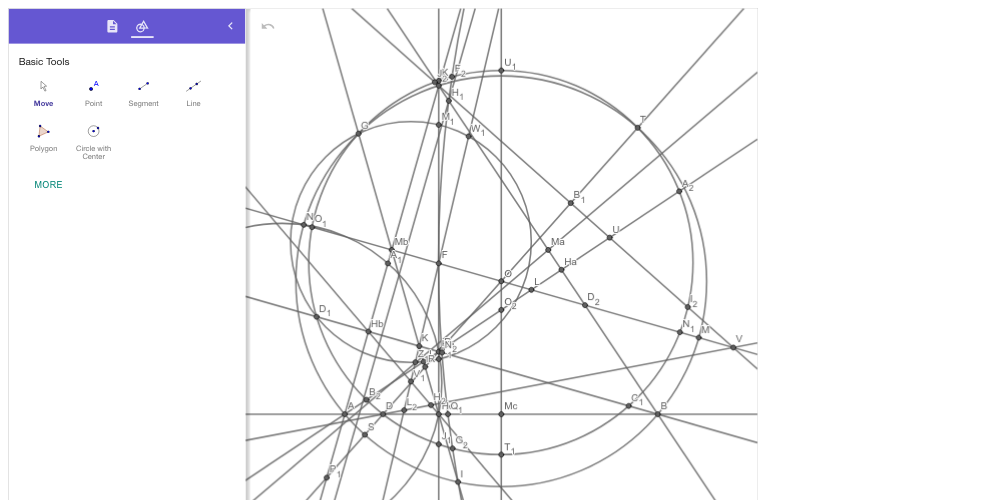

ggb backend closed


In [3]:
e = Env({'headless' : True})
await e.run()
log = open('log.txt', 'w+')

for i in range(25):
    print(i)
    op = e.object_pool
    print('op:', op, file=log)
    
    options = [
        (line, rnd2.sample(op['p'], 2)),
        (circle, rnd2.sample(op['p'], 3))
    ]
    
    if len(op['l']) >= 1: options.append((perpendicular, [rnd2.choice(op['p']), rnd2.choice(op['l'])]))
    if len(op['l'] + op['c']) >= 2: options.append((intersect, rnd2.sample(op['l'] + op['c'], 2)))
    
    t, args = rnd2.sample(options, 1)[0]

    if i % 2 == 0 and len(op['l'] + op['c']) >= 2:
        for i in range(10): await e.action(intersect, rnd2.sample(op['l'] + op['c'], 2))
    
    print(t, args, file=log)
    await e.action(t, args)


await e.ggb.screenshot()
display(Image('./data/example.png'))
await e.ggb.stop()
log.close()

EDGES = e.graph.edges

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
from IPython.display import Image

import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt

%matplotlib inline

from pyvis.network import Network
import pandas as pd

got_net = Network(height="750px", width="100%", bgcolor="#222222", font_color="white")
got_net.barnes_hut()

EDGES = e.graph.edges

edge_data = []
for v, es in EDGES.items():
    for ee in es:
        u, t = ee
        edge_data.append(tuple((str(v), str(u), int(t))))
# print(edge_data)

vcs = {'p' : 'white', 'l' : 'gray', 'c' : 'black', '' : 'pink'}
ecs = ['kek', 'blue', 'red']

for src, dst, w in edge_data:
    got_net.add_node(src, src, title=src, shape='dot', color = vcs[e.types[src]])
    got_net.add_node(dst, dst, title=dst, shape='circle', color = vcs[e.types[dst]])
    got_net.add_edge(src, dst, value=1, color=ecs[w])

neighbor_map = got_net.get_adj_list()


got_net.show("lol.html")

from IPython.display import IFrame
IFrame(src='./lol.html', width=1000, height=1200)